Lambda_beta_k_t value based on the '5G Outdoors' heatmap region: 22.87
Hour 0: Total Power Consumption = 35.20 kW
Hour 1: Total Power Consumption = 35.20 kW
Hour 2: Total Power Consumption = 35.20 kW
Hour 3: Total Power Consumption = 35.21 kW
Hour 4: Total Power Consumption = 35.20 kW
Hour 5: Total Power Consumption = 35.20 kW
Hour 6: Total Power Consumption = 35.05 kW
Hour 7: Total Power Consumption = 35.05 kW
Hour 8: Total Power Consumption = 35.05 kW
Hour 9: Total Power Consumption = 35.05 kW
Hour 10: Total Power Consumption = 35.05 kW
Hour 11: Total Power Consumption = 35.20 kW
Hour 12: Total Power Consumption = 35.21 kW
Hour 13: Total Power Consumption = 35.20 kW
Hour 14: Total Power Consumption = 35.21 kW
Hour 15: Total Power Consumption = 35.05 kW
Hour 16: Total Power Consumption = 35.05 kW
Hour 17: Total Power Consumption = 35.21 kW
Hour 18: Total Power Consumption = 35.20 kW
Hour 19: Total Power Consumption = 35.21 kW
Hour 20: Total Power Consumption = 35.21 kW
Hour 21: Total 

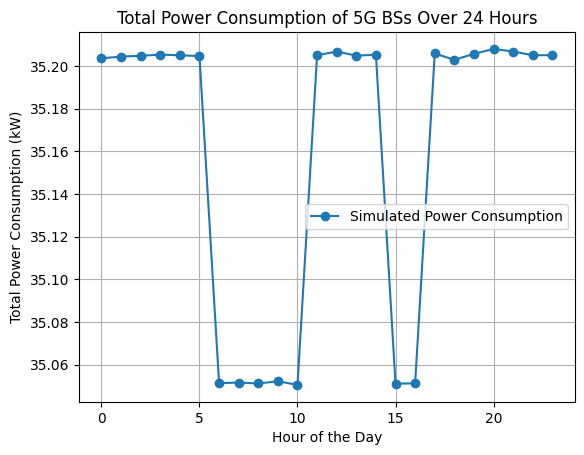

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Convert hex colors to RGB
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

# Define the color range for '5G Outdoors'
lower_color = hex_to_rgb('8079E4')  # Lower bound of '5G Outdoors'
upper_color = hex_to_rgb('877FE9')  # Upper bound of '5G Outdoors'

# Load the heatmap image
heatmap_image = cv2.imread('lakemba.png') # Lakemba is a residential area
heatmap_image = cv2.cvtColor(heatmap_image, cv2.COLOR_BGR2RGB)

# Create a mask for the '5G Outdoors' color range
lower = np.array(lower_color, dtype="uint8")
upper = np.array(upper_color, dtype="uint8")
mask = cv2.inRange(heatmap_image, lower, upper)

# Count the number of pixels that match the '5G Outdoors' color range
aggregation_count = cv2.countNonZero(mask)

# Normalize aggregation levels to calculate lambda_beta_k_t
total_pixels = heatmap_image.shape[0] * heatmap_image.shape[1]
lambda_beta_k_t = (aggregation_count / total_pixels) * 100  # Scale to a typical value

print(f"Lambda_beta_k_t value based on the '5G Outdoors' heatmap region: {lambda_beta_k_t:.2f}")

# Constants (Example values, replace with actual data)
Nk = 10  # Number of 5G BSs in the area
Tdd_max = 1000  # Maximum downlink data rate [Mbps]
Rds_max = 500  # Maximum signaling REs [RE/s]
Pmax_AAU = 5  # Maximum power consumption of AAU [kW]
Pb_AAU = 2  # Baseline power consumption of AAU [kW]
Pb_BBU = 1  # Baseline power consumption of BBU [kW]
Pac_pe = 0.5  # Power consumption of air conditioning and power equipment per BS [kW]
ARE = 1  # Average amount of downlink data carried per RE [Mbps/RE]
Nm = 1000  # Number of Monte Carlo samples

# Correct use_state based on Figure 8(c)
use_state = ['normal'] * 24
for i in list(range(0, 6)) + list(range(11, 15)) + list(range(17, 24)):
    use_state[i] = 'heavy'

# Use percentages instead of fixed numbers for expected activated terminals
expected_activated_terminals_percentage = {
    'normal': 0.25,  # 25% for normal state
    'heavy': 1.00    # 100% for heavy state
}

# Monte Carlo Simulation
hours = np.arange(0, 24)
P_S_total_k = np.zeros_like(hours, dtype=float)

for t in hours:
    # Determine the percentage of activated terminals for the current hour
    percentage = expected_activated_terminals_percentage[use_state[t]]
    
    # Step 1: Generate hourly activated terminals based on Poisson distribution
    beta_k_t_samples = np.random.poisson(lambda_beta_k_t * percentage, Nm)
    
    # Initialize accumulators for Monte Carlo simulation
    Tdd_k_t_sum = 0
    Rds_k_t_sum = 0
    
    for beta_k_t in beta_k_t_samples:
        # Step 2: Calculate total downlink data rate and signaling REs for each sample
        Tdd_k_t = min(Nk * Tdd_max, beta_k_t * ARE)
        Rds_k_t = min(Nk * Rds_max, Tdd_k_t / ARE)
        
        # Accumulate values
        Tdd_k_t_sum += Tdd_k_t
        Rds_k_t_sum += Rds_k_t
    
    # Average the accumulated values over all Monte Carlo samples
    Tdd_k_t_avg = Tdd_k_t_sum / Nm
    Rds_k_t_avg = Rds_k_t_sum / Nm
    
    # Step 3: Calculate incremental power consumption of AAU
    Pidd_AAU_k_t = Nk * (Pmax_AAU - Pb_AAU) / Tdd_max * (Tdd_k_t_avg / Nk)
    Pids_AAU_k_t = Nk * (Pmax_AAU - Pb_AAU) / Rds_max * (Rds_k_t_avg / Nk)
    
    # Step 4: Calculate total power consumption for AAU
    Pi_AAU_k_t = Pidd_AAU_k_t + Pids_AAU_k_t
    
    # Step 5: Calculate total power consumption of 5G BS in area k
    Pwe_k_t = Pi_AAU_k_t + Nk * Pb_AAU + Nk * Pb_BBU
    
    # Step 6: Calculate final total power consumption including air conditioning and power equipment
    P_S_total_k[t] = Pwe_k_t + Nk * Pac_pe

# Output the total power consumption per hour with standard formatting
for t, P in zip(hours, P_S_total_k):
    print(f"Hour {t}: Total Power Consumption = {P:.2f} kW")

# Plotting with formatted y-axis labels and comparison
plt.plot(hours, P_S_total_k, marker='o', label='Simulated Power Consumption')
plt.title("Total Power Consumption of 5G BSs Over 24 Hours")
plt.xlabel("Hour of the Day")
plt.ylabel("Total Power Consumption (kW)")
plt.grid(True)

# Adjust the y-axis to avoid scientific notation
plt.ticklabel_format(style='plain', axis='y')
plt.legend()
plt.show()


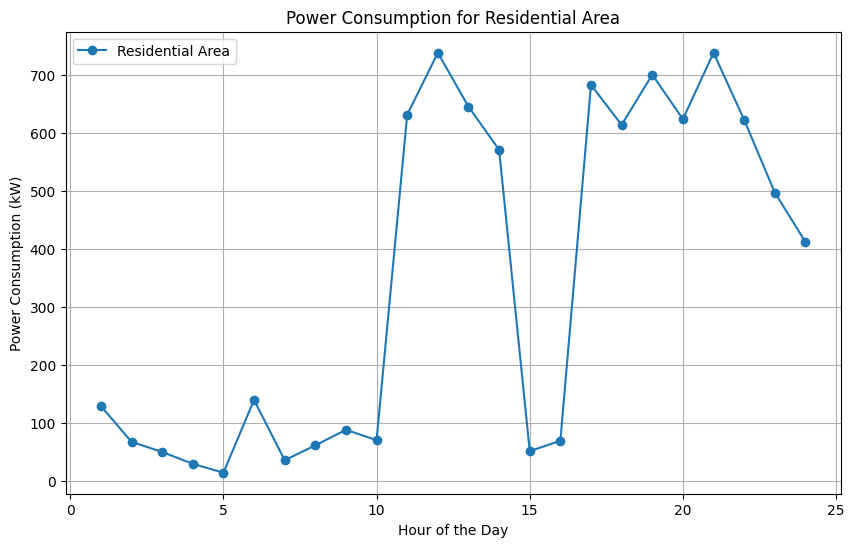

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Define the required data
# Activated terminals data for residential, shopping, and office areas
activated_terminals = {
    "time": np.arange(1, 25),
    "residential": [470, 240, 200, 100, 50, 500, 1250, 2100, 3000, 2450, 2200, 2600, 2350, 2150, 1800, 2400, 2450, 2250, 2450, 2275, 2800, 2250, 1850, 1500],
    "shopping": [100, 50, 100, 100, 50, 50, 125, 500, 1850, 2400, 2100, 2370, 2850, 2700, 2750, 2775, 2800, 2820, 3200, 3500, 2600, 1800, 1600, 800],
    "office": [50, 50, 50, 50, 50, 50, 470, 900, 2720, 2650, 2700, 2400, 2200, 2000, 2200, 2100, 2150, 2050, 2450, 1500, 1000, 500, 250, 50]
}

# Normal/Heavy use state for residential, shopping, and office areas
use_state = {
    "time": np.arange(1, 25),
    "residential": ['h', 'h', 'h', 'h', 'h', 'h', 'n', 'n', 'n', 'n', 'h', 'h', 'h', 'h', 'n', 'n', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h'],
    "shopping": ['n', 'n', 'n', 'n', 'n', 'n', 'h', 'h', 'n', 'n', 'n', 'h', 'h', 'h', 'n', 'n', 'h', 'h', 'h', 'h', 'h', 'n', 'n', 'n'],
    "office": ['n', 'n', 'n', 'n', 'n', 'n', 'h', 'h', 'n', 'n', 'n', 'h', 'h', 'n', 'n', 'n', 'n', 'h', 'h', 'n', 'n', 'n', 'n', 'n']
}

# Define bandwidth requirements for different services
bandwidth_requirements = {
    "non_video": 1,
    "video_8k": 60,
    "ar_vr_2d_12k": 100,
    "ar_vr_3d_8k": 135
}

# Define power consumption parameters for AAU, BBU, air conditioning, etc.
power_params = {
    "P_max_AAU": 1.5,    # kW
    "P_base_AAU": 0.5,   # kW
    "P_base_BBU": 0.3,   # kW
    "P_ac_pe": 0.1       # kW
}

# Step 2: Convert the data into DataFrames for easier processing
df_terminals = pd.DataFrame(activated_terminals)
df_use_state = pd.DataFrame(use_state)

# Step 3: Define functions to simulate terminal activations and data usage based on distributions

# Simulate the number of activated terminals using Poisson distribution
def simulate_activated_terminals(expected_value, num_samples=1000):
    return np.random.poisson(lam=expected_value, size=num_samples)

# Simulate data usage based on exponential distribution for normal and heavy states
def data_usage_model(use_state, heavy_mean, normal_mean, num_samples=1000):
    if use_state == 'h':
        return np.random.exponential(scale=heavy_mean, size=num_samples)
    else:
        return np.random.exponential(scale=normal_mean, size=num_samples)

# Step 4: Define Monte Carlo sampling functions to generate data

def monte_carlo_sampling_activated_terminals(area, num_samples=1000):
    """
    Perform Monte Carlo sampling for hourly activated terminals.
    Returns the simulated terminal activations for each hour.
    """
    simulated_terminals = {}
    for hour in df_terminals['time']:
        expected_terminals = df_terminals[area].iloc[hour - 1]  # Get expected value for the hour
        simulated_terminals[hour] = simulate_activated_terminals(expected_terminals, num_samples)
    return simulated_terminals

def monte_carlo_sampling_data_usage(area, num_samples=1000):
    """
    Perform Monte Carlo sampling for hourly data usage per terminal.
    Returns the simulated data usage for each hour.
    """
    simulated_data_usage = {}
    for hour in df_use_state['time']:
        current_state = df_use_state[area].iloc[hour - 1]  # Get the use state (h/n)
        # Example: heavy use mean = 100 MB, normal use mean = 10 MB (adjust as needed)
        simulated_data_usage[hour] = data_usage_model(
            current_state, heavy_mean=100, normal_mean=10, num_samples=num_samples
        )
    return simulated_data_usage

# Step 5: Calculate total data usage for each area at each hour

def calculate_total_data_usage(area, num_samples=1000):
    """
    Calculate total data usage for the area by combining activated terminals
    and data usage per terminal.
    """
    activated_terminals = monte_carlo_sampling_activated_terminals(area, num_samples)
    data_usage = monte_carlo_sampling_data_usage(area, num_samples)
    
    total_data_usage = {}
    
    for hour in range(1, 25):  # Loop through each hour
        # Total data usage is the sum of usage for all activated terminals
        total_data_usage[hour] = np.sum(
            activated_terminals[hour] * data_usage[hour]
        )
    
    return total_data_usage

# Step 6: Calculate power consumption based on data usage and power model

def calculate_power_consumption(area, num_samples=1000):
    """
    Calculate the total power consumption for the area based on data usage and the power model.
    """
    total_data_usage = calculate_total_data_usage(area, num_samples)
    
    total_power_consumption = {}
    
    for hour in range(1, 25):
        # Calculate incremental power consumption
        T_dd = total_data_usage[hour] / 3600  # Convert MB to MBps
        P_i_AAU = (power_params["P_max_AAU"] - power_params["P_base_AAU"]) * T_dd / 100  # Scale factor for AAU
        
        # Total power consumption (P_total = P_i_AAU + baseline power + air conditioning)
        total_power_consumption[hour] = (
            P_i_AAU + power_params["P_base_AAU"] + power_params["P_base_BBU"] + power_params["P_ac_pe"]
        )
    
    return total_power_consumption

# Step 7: Run the model for a specific area and calculate the total power consumption

def run_power_consumption_model(area, num_samples=1000):
    total_power = calculate_power_consumption(area, num_samples)
    
    # Convert the power consumption to a DataFrame for easier analysis and plotting
    df_power = pd.DataFrame({
        "Hour": np.arange(1, 25),
        "Power Consumption (kW)": [total_power[hour] for hour in range(1, 25)]
    })
    
    # Plot the power consumption for visualization
    plt.figure(figsize=(10, 6))
    plt.plot(df_power["Hour"], df_power["Power Consumption (kW)"], marker='o', label=f'{area.capitalize()} Area')
    plt.title(f"Power Consumption for {area.capitalize()} Area")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Power Consumption (kW)")
    plt.grid(True)
    plt.legend()
    plt.show()

    return df_power

# Example: Running the model for the residential area
df_residential_power = run_power_consumption_model('residential', num_samples=1000)

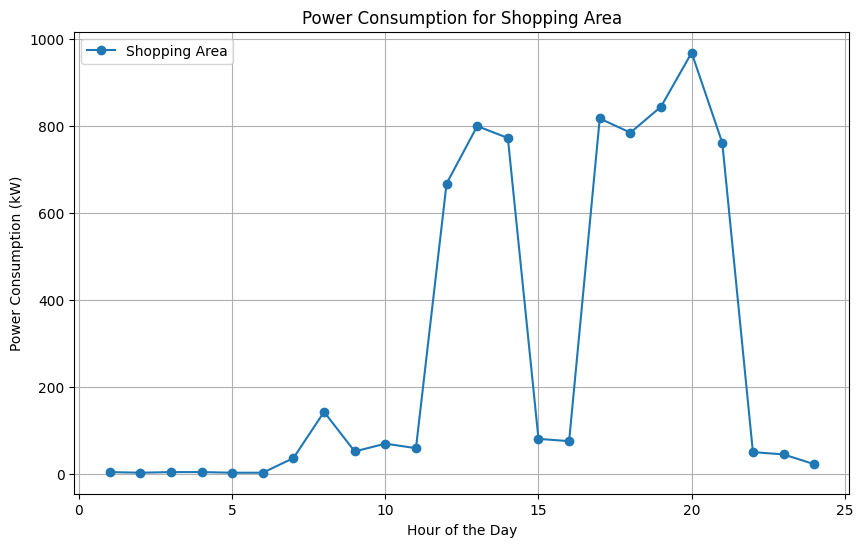

In [15]:
# Example: Running the model for the residential area
df_residential_power = run_power_consumption_model('shopping', num_samples=1000)

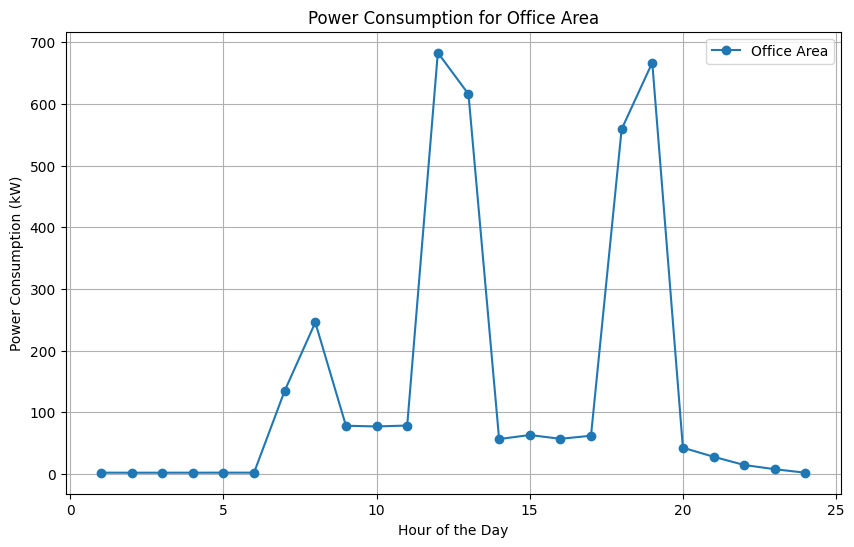

In [16]:
# Example: Running the model for the residential area
df_residential_power = run_power_consumption_model('office', num_samples=1000)